In [211]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras import layers, models
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers.legacy import Adagrad, SGD, Adam
import cv2

In [2]:
def open_data(path):

    # Path to the folder where HDF5 files are saved
    input_folder = path#

    # Initialize an empty list to store image data
    image_data_list = []
    cloud_map_data_list = []

    # Iterate over files in the folder
    for filename in os.listdir(input_folder):
        # Check if the file is an HDF5 file
        if filename.endswith(".h5"):
            input_path = os.path.join(input_folder, filename)

            with h5py.File(input_path, 'r') as file:
                # Check if 'image' dataset exists in the file
                if 'image' in file:
                    img_data = file['image'][:]
                    cp_data = file['cloud_map'][:]

                    img_max_val = np.max((np.abs(img_data)))
                    img_data = img_data/img_max_val

                    image_data_list.append(img_data)
                    cloud_map_data_list.append(cp_data)
                else:
                    print(f"Dataset 'image' not found in file: {input_path}")

    # Convert the list of image data to a numpy array
    image_data = np.array(image_data_list)
    cloud_map_data = np.array(cloud_map_data_list)

    # Display the shape of the resulting array
    print(f"Shape of the image data array: {image_data.shape}")
    print(f"Shape of the cloud map data array: {cloud_map_data.shape}")

    return image_data, cloud_map_data

def cut_images(image_data, section_size):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = image.shape[0] // section_size
        num_cols = image.shape[1] // section_size

        # Cut the image into sections
        for i in range(num_rows):
            for j in range(num_cols):
                row_start, row_end = i * section_size, (i + 1) * section_size
                col_start, col_end = j * section_size, (j + 1) * section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)


In [3]:
image_data, cloud_map_data = open_data('/Users/lukas/Dokumente/Uni/SSI/CNN_data/')

Shape of the image data array: (44, 512, 640, 1)
Shape of the cloud map data array: (44, 512, 640, 1)


In [ ]:
# Define the downsampling factor, for example, let's downsample by a factor of 2
downsampling_factor = 2

# Resize the binary pixel map using OpenCV
cpm_d2 = cv2.resize(cpm, (cpm.shape[0] // downsampling_factor, cpm.shape[1] // downsampling_factor), interpolation=cv2.INTER_AREA)
cpm_d2[cpm_d2>=0.5] = 1
cpm_d2[cpm_d2<0.5] = 0


In [176]:
section_size = 128
cut_frames = cut_images(image_data, section_size=section_size)
cut_labels = cut_images(cloud_map_data, section_size=section_size)
input_shape=(section_size, section_size, 1)

Shape of the new data array: (880, 128, 128, 1)
Shape of the new data array: (880, 128, 128, 1)


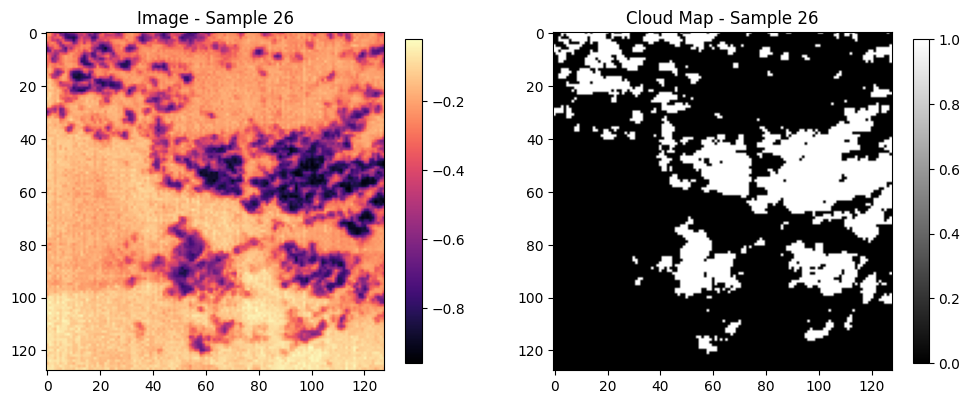

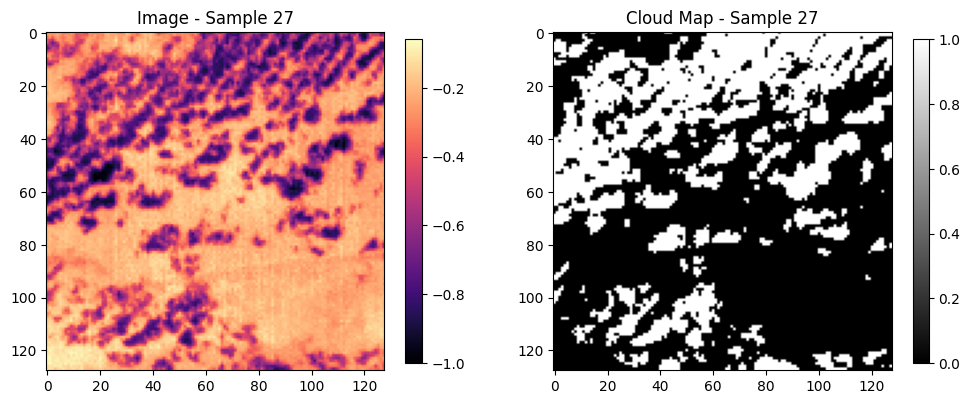

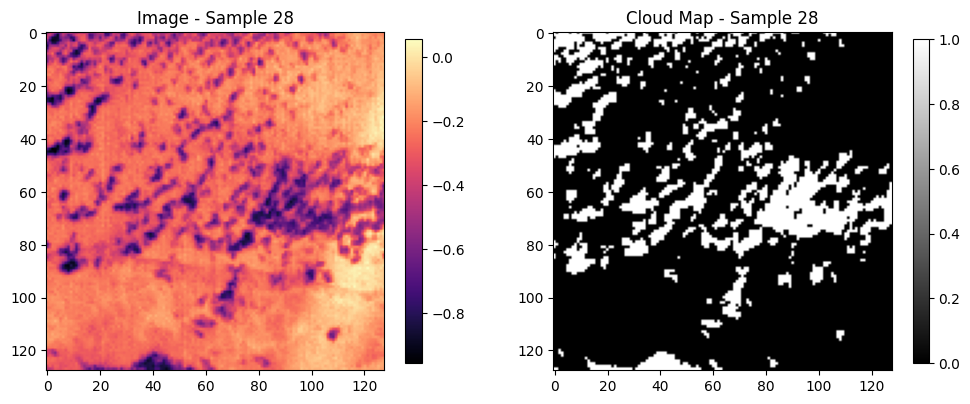

In [195]:
# Number of samples to plot
num_samples = 3
i_offset = 25

# Plot the images and their corresponding cloud maps
for i in range(num_samples):
    plt.figure(figsize=(12, 6))

    # Plot the first image
    plt.subplot(1, 2, 1)
    plt.imshow(cut_frames[i + i_offset, :, :, 0], cmap='magma')
    plt.title(f'Image - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    # Plot the corresponding cloud map
    plt.subplot(1, 2, 2)
    plt.imshow(cut_labels[i + i_offset, :, :, 0], cmap='binary_r')
    plt.title(f'Cloud Map - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    plt.show()

In [206]:
image_train, image_test, cloud_train, cloud_test = train_test_split(cut_frames, cut_labels, test_size=0.2, random_state=42)


In [196]:
model = models.Sequential()

# Encoder
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.1))

# model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

# model.add(layers.UpSampling2D(size=(2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.2))

model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model.add(layers.Dropout(0.1))

model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#model.add(layers.Dropout(0.1))

# Output layer
model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))

#optimizer = Adam(learning_rate=0.001)
#optimizer = Adagrad(learning_rate=0.001)
optimizer = SGD(learning_rate=0.005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270 (Conv2D)         (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_248 (B  (None, 128, 128, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_271 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_249 (B  (None, 128, 128, 64)      256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                     

In [369]:
datagen = ImageDataGenerator(
    #rotation_range=45,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.5,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.5, # Randomly shift images vertically (fraction of total height)
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    fill_mode='reflect'
)

batch_size = 16
steps_per_epoch = len(image_train) // batch_size

# Fit the data generator to the training data (assuming you have a variable named 'train_images')
datagen.fit(image_train)
gen_seed = 42

# Create a generator for both the input images and the ground truth masks
image_generator = datagen.flow(image_train, batch_size=batch_size, seed=gen_seed)
mask_generator = datagen.flow(cloud_train, batch_size=batch_size, seed=gen_seed)

# Combine the generators into one using zip
train_generator = zip(image_generator, mask_generator)

#aug_train_images = datagen.flow(image_train, cloud_train, batch_size=batch_size)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a ModelCheckpoint callback to save the model at each epoch
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_best_only=False)



In [11]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.yticks(np.arange(0.8,1.01,0.01))
    #plt.ylim(0.89,1)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [373]:
history = model.fit(image_train, cloud_train, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=(image_test, cloud_test), callbacks=[early_stopping])

44/44 [==============================] - 91s 2s/step - loss: 0.1436 - accuracy: 0.9394 - val_loss: 0.1695 - val_accuracy: 0.9270


In [370]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, validation_data=(image_test, cloud_test), callbacks=[early_stopping])

Epoch 1/5
44/44 [==============================] - 91s 2s/step - loss: 0.1708 - accuracy: 0.9072 - val_loss: 0.1121 - val_accuracy: 0.9542
Epoch 2/5
44/44 [==============================] - 90s 2s/step - loss: 0.1754 - accuracy: 0.9039 - val_loss: 0.1853 - val_accuracy: 0.9155
Epoch 3/5
44/44 [==============================] - 90s 2s/step - loss: 0.1763 - accuracy: 0.9039 - val_loss: 0.1333 - val_accuracy: 0.9414
Epoch 4/5
44/44 [==============================] - 90s 2s/step - loss: 0.1652 - accuracy: 0.9106 - val_loss: 0.3202 - val_accuracy: 0.8895
Epoch 5/5
44/44 [==============================] - 90s 2s/step - loss: 0.1763 - accuracy: 0.9053 - val_loss: 0.3183 - val_accuracy: 0.9035


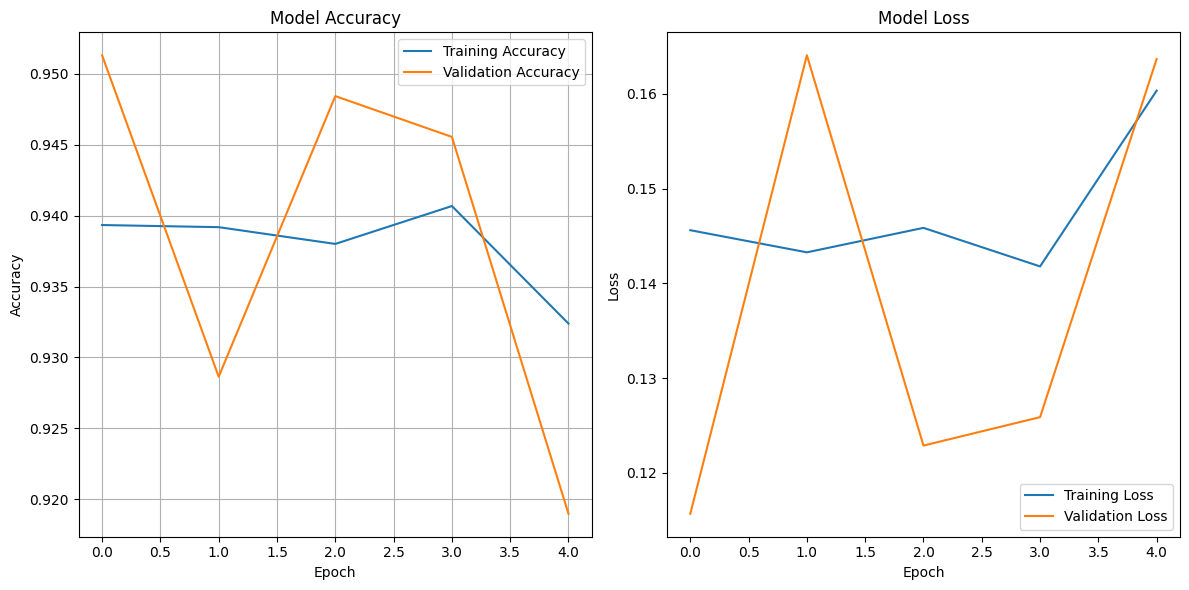

In [372]:
plot_history(history)

In [374]:
# Predict on test data
predictions = model.predict(image_test)

6/6 [==============================] - 6s 1s/step


129


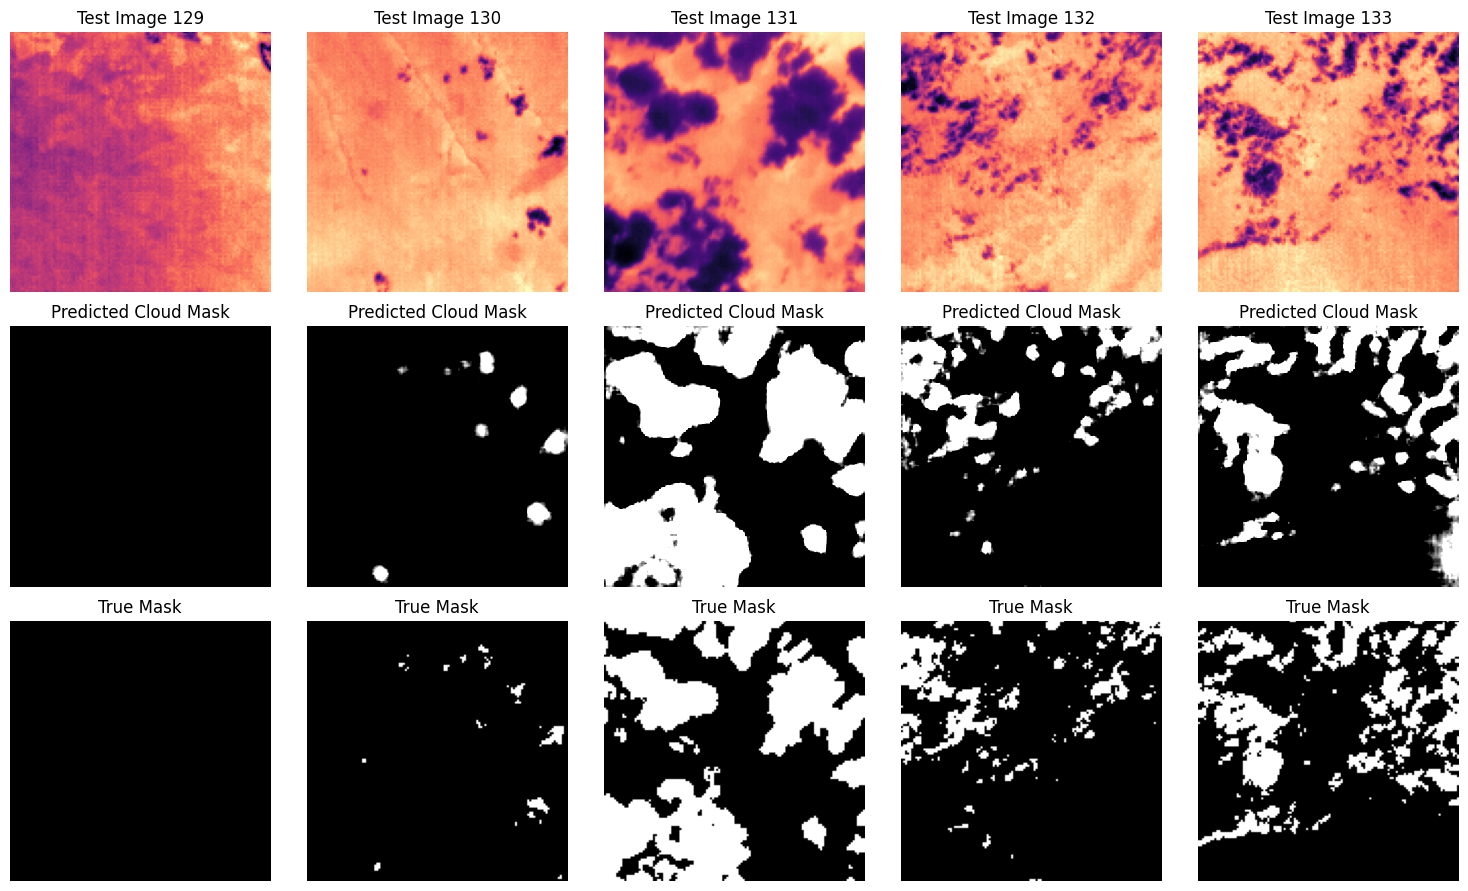

In [384]:
# Plot a few samples
num_samples = 5  # You can change this number based on your preference
plt.figure(figsize=(15, 9))

rand_offset = random.randint(0, image_test.shape[0]-num_samples-1)
print(rand_offset)

for i in range(num_samples):
    # Original image (input)
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(image_test[i + rand_offset, :, :, 0], cmap='magma')
    plt.title('Test Image ' + str(i + rand_offset))
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(3, num_samples, i + 1 + num_samples)
    plt.imshow(predictions[i + rand_offset, :, :, 0], cmap='binary_r', vmin=0.25, vmax=0.5)
    plt.title('Predicted Cloud Mask')
    plt.axis('off')

    # True mask
    plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(cloud_test[i + rand_offset, :, :, 0], cmap='binary_r', vmin=0.0, vmax=1)
    plt.title('True Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save('best_IR_img2cpm.h5')

In [164]:
a = [(i, j.mean()) for i, j in enumerate(cloud_map_data) if j.mean()==0]
a, cloud_map_data.shape

([(2, 0.0),
  (5, 0.0),
  (13, 0.0),
  (14, 0.0),
  (20, 0.0),
  (21, 0.0),
  (22, 0.0),
  (28, 0.0),
  (30, 0.0),
  (31, 0.0),
  (33, 0.0)],
 (34, 512, 640, 1))